#  How to create a Fall Detection Application using Panoramasdk

#### Goal of this Notebook :
* Aid an Panorama SDK developer prototype their application before creating the PanoramaSDK Lambda
* Creating an MXNET application in the same structure as the PanoramaSDK Lambda
* Create and Deploy the PanoramaSDK Lambda from this notebook

#### Application Use Case :
* Detect Fall with `simplepose`, a pose estimation model
* Time the fall and display the fall metrics

#### Useful Resources to aid your development :
* [AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)




## Exploratory Data Analysis

Let's explore a video from [URD Dataset](http://le2i.cnrs.fr/Fall-detection-Dataset?lang=fr) , one of the common datasets used for training a Fall Detection model.  <br>
**Note:**  Use conda_mxnet_p36 kernel to run this notebook and install GluonCV

In [4]:
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


#### Import required roles

In [5]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [6]:
from IPython.display import Video, clear_output, Markdown, display

# notebook helper script
from nb_utils import get_frames, get_video_stats, get_predictions, to_mx, to_np

# lambda helper script
from notebook_utils import (
    preprocess,
    detector_to_simple_pose,
    heatmap_to_coord,
    update_x,
    update_y,
    reset_tracker,
    reset_counts,
)

video_path = "sample_video.mp4"
video_stats = get_video_stats(video_path)
Video(video_path)

Total Frames & FPS :  701 ,  120
Video Duration     :  0 mins  5 secs
Video Resolution :  (480, 720, 3)


Common Observations on fall:

- There is a steep change in y-coordinates of human-body keypoints
- The ankle to shoulder y-coordinate distance reduces as the person falls
- The head/upper body moves at high velocity downwards (y-axis) during a fall compared to regular walking action

To build a simple fall detector, we need to be able to detect and track presence of keypoints from frame to frame and incorporate custom post processing logic. <br>
The potential models that can help achieve this are explained below.

## Modelling Approach

Keypoint Detection in a top-down approach is a two step process:

- Step 1: Indentify the presence of "person" in the frame with a bounding box(bbox) using an Object Detection model.
- Step 2: Predict the keypoints of the person from the bbox image using a Pose Estimation model.

To simplify, let's start with a single person fall detection algorithm. 

GluonCV Model Zoo (https://gluon-cv.mxnet.io/model_zoo/) offers a range pretrained models with several architecture and backbone network combinations to choose from, for various latency and performance considerations. <br>
For this application `ssd_512_resnet50_v1_coco` will be used for person detection and `simple_pose_resnet50_v1d` for human-body keypoint detection.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

# dependencies for model
import mxnet as mx
from mxnet import nd
from gluoncv.model_zoo import get_model
from gluoncv import data, utils

# lambda helper script
from notebook_utils import (
    preprocess,
    detector_to_simple_pose,
    heatmap_to_coord,
    update_x,
    update_y,
    reset_tracker,
    reset_counts,
)

In [8]:
# Input image from video
sample_frames = get_frames(video_path, frame_nums=range(0, video_stats["total_frames"]))
sample_frames[0].shape

(480, 720, 3)

In [9]:
# Preprocessed image size for model
img_size = (512, 512)
# Object Detection confidence threshold
conf_thresh = 0.1
# Valid bbox size for person detection
box_size_thresh = (75, 75)

# Load pre-trained object detection model and reset classes to get only predictions for person
detector_model = get_model(name="ssd_512_resnet50_v1_coco", pretrained=True)
detector_model.reset_class(["person"], reuse_weights=["person"])

# Load pose estimation model
pose_model = get_model(name="simple_pose_resnet50_v1d", pretrained=True)

#### Step 1: Person Detection

In [10]:
x, orig_img = preprocess(sample_frames[200], img_size)
x, orig_img = mx.nd.array(x), mx.nd.array(orig_img)
class_ids, scores, bboxes = detector_model(x)

class_ids.shape, scores.shape, bboxes.shape

((1, 100, 1), (1, 100, 1), (1, 100, 4))

class_ids - top 100 classes of objects in the image. The class_id for `person` class is 0 <br>
scores - confidence scores for the class predictions <br>
bboxes - the top-left, bottom-right (x,y) coordinates bounding box that surrounds the object of interest<br>

In [11]:
# top predictions
print("Class id : ", class_ids[0][0].asscalar())
print("Confidence score : ", scores[0][0].asscalar())
print("Bounding box prediction : ", bboxes[0][0].asnumpy())

Class id :  0.0
Confidence score :  0.99557734
Bounding box prediction :  [408.3736  129.32744 483.95972 330.01538]


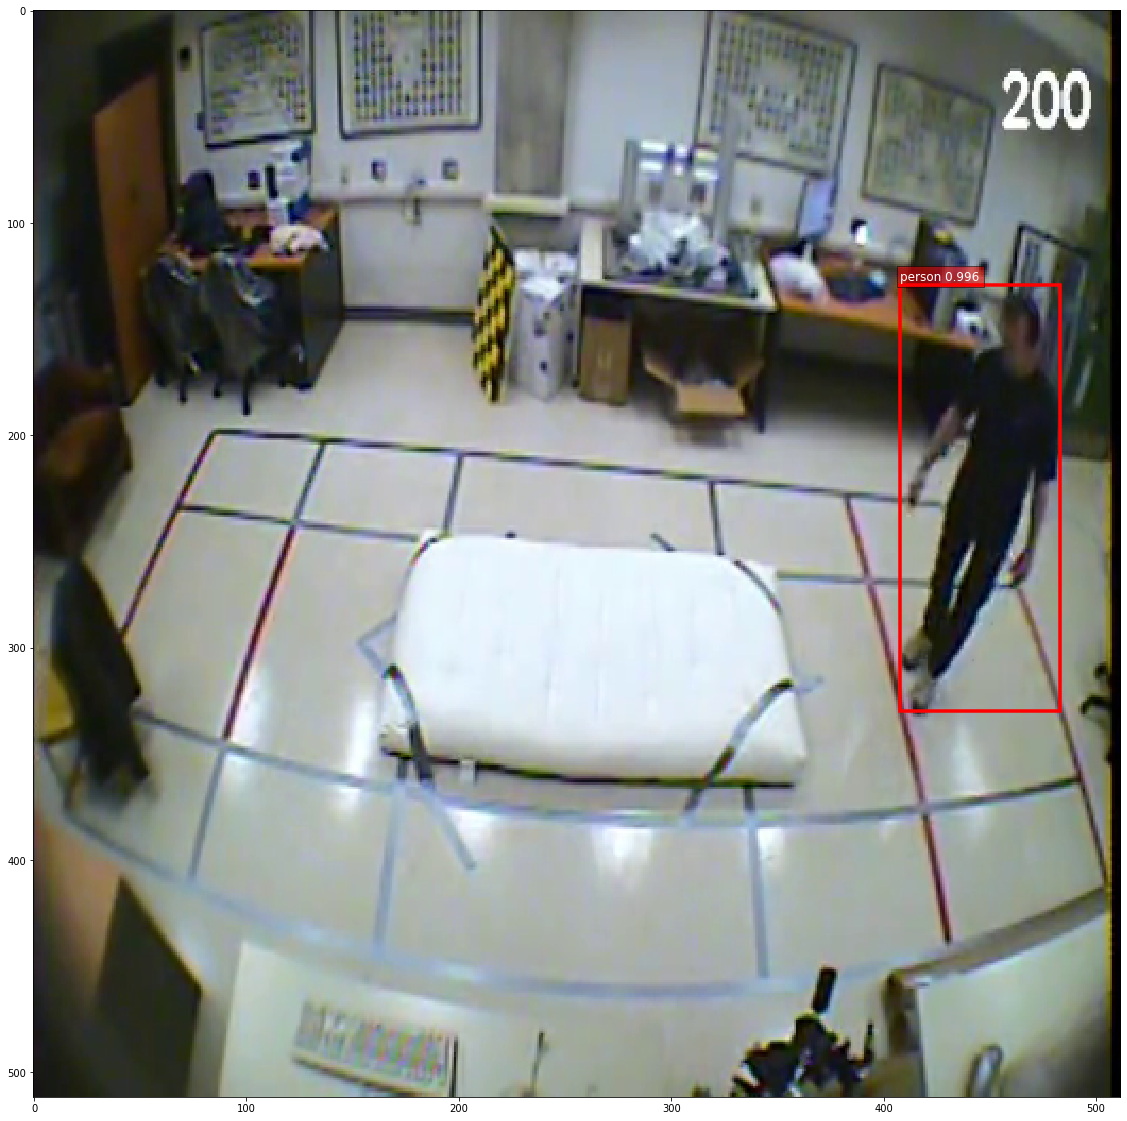

In [12]:
ax = utils.viz.plot_bbox(
    orig_img, bboxes[0], scores[0], class_ids[0], class_names=detector_model.classes
)
plt.show()

**Defining valid object detection prediction:**

* Filter only the top-most confindent prediction from object detection model (single person tracking) and check for confidence $\gt$  `conf_thresh`
* Remove false positive predictions from the surrounding objects which has bounding box dimensions (w,h) less than a certain `box_size_thresh`

#### Step 2: Pose Estimation/ Key point detection

In [13]:
# bbox coordinates of most confident prediction
x_min, y_min, x_max, y_max = (
    bboxes[0][0][0],
    bboxes[0][0][1],
    bboxes[0][0][2],
    bboxes[0][0][3],
)
w, h = (x_max - x_min).asscalar(), (y_max - y_min).asscalar()

# do pose estimation only for valid preidctions
if (
    (scores[:, 0:1, :][0][0].asscalar() > conf_thresh)
    and w > box_size_thresh[0]
    and h > box_size_thresh[1]
):

    # crop the image with bbox prediction from detector_model
    # process it for pose_model
    orig_img, class_ids, scores, bboxes = (
        to_np(orig_img),
        to_np(class_ids),
        to_np(scores),
        to_np(bboxes),
    )
    pose_input, upscale_bbox = detector_to_simple_pose(
        orig_img,
        class_ids[:, 0:1, :],
        scores[:, 0:1, :],
        bboxes[:, 0:1, :],
        thr=conf_thresh,
        person_id=0,
    )

    pose_input, upscale_bbox = to_mx(pose_input), to_mx(upscale_bbox)

    # Get keypoint heatmap predictions
    predicted_heatmap = pose_model(pose_input)
    predicted_heatmap, upscale_bbox = to_np(predicted_heatmap), to_np(upscale_bbox)

    # Convert the heat map to (x,y) coordinate space in the frame and return confidence scores for 17 keypoints
    pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

In [14]:
print("SimplePose model input image dimension  :", pose_input.shape)
print("SimplePose model output tensor dimension  :", predicted_heatmap.shape)
print("Processed prediction coordinates dimension  :", pred_coords.shape)
print("Processed confidence scores dimension  :", confidence.shape)

SimplePose model input image dimension  : (1, 3, 256, 192)
SimplePose model output tensor dimension  : (1, 17, 64, 48)
Processed prediction coordinates dimension  : (1, 17, 2)
Processed confidence scores dimension  : (1, 17, 1)


The SimplePose model predicts the coordinates and confidence scores for 17 keypoints in the body in the order: <br>

[ nose, left_eye, right_eye, left_ear, right_ear, left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle ]

#### Step 3: Track metrics for fall

Frame number :  290
Ankle shoulder distance :  153.506


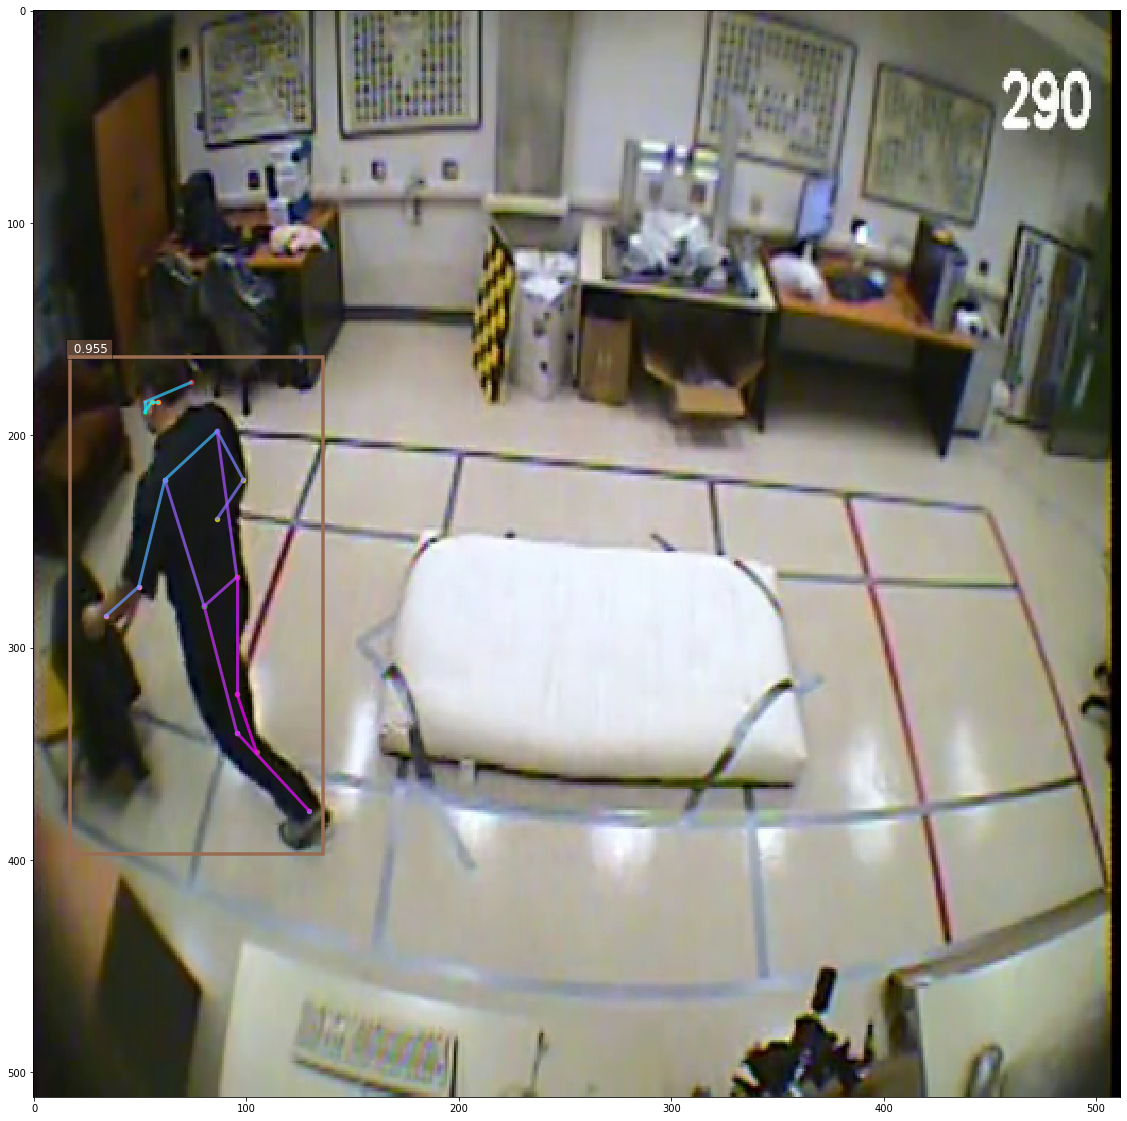

Frame number :  400
Ankle shoulder distance :  96.789


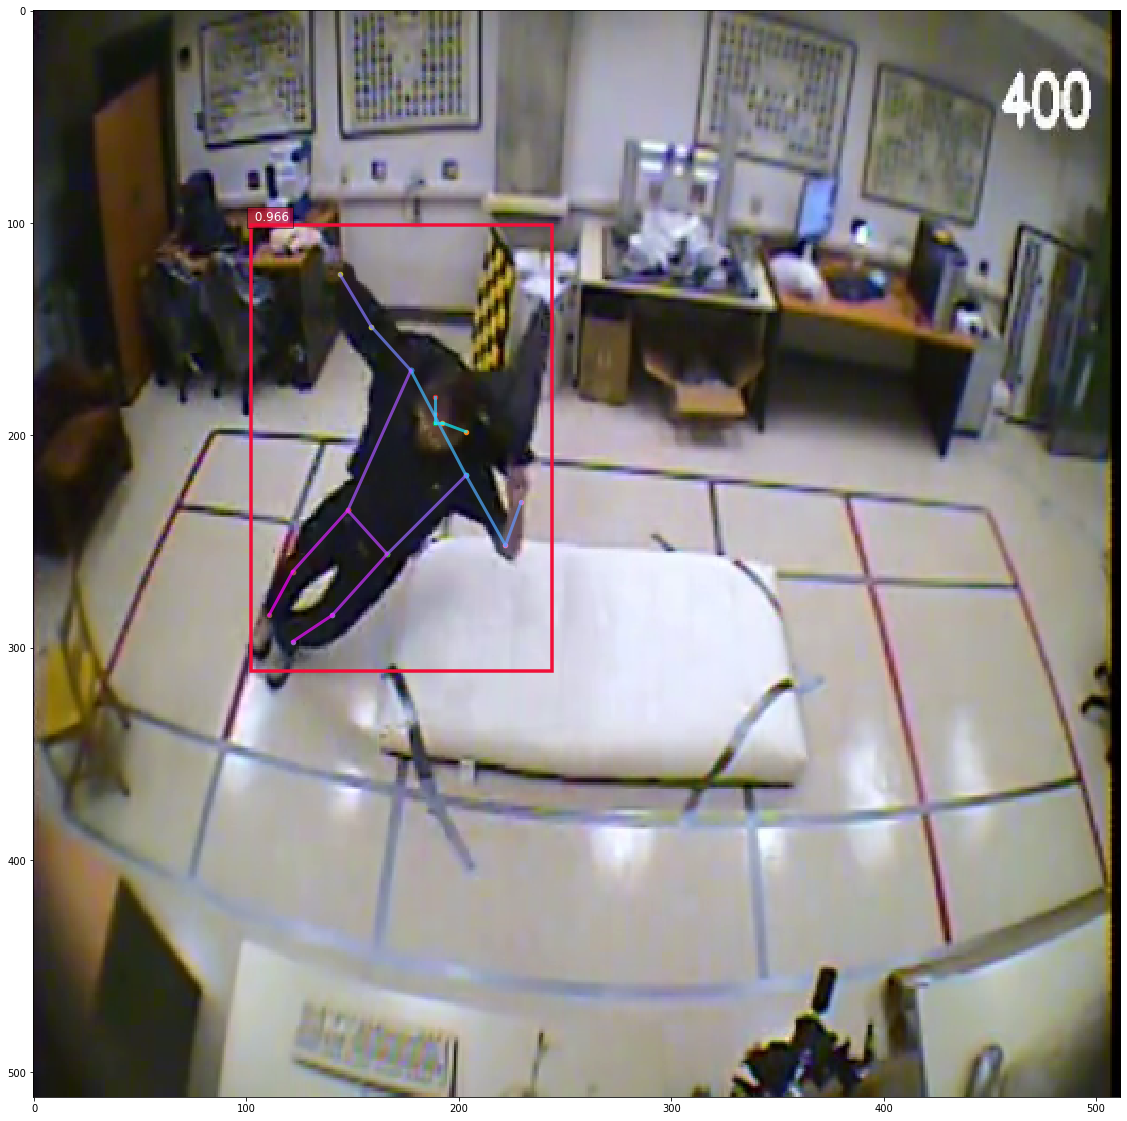

Frame number :  633
Ankle shoulder distance :  25.882


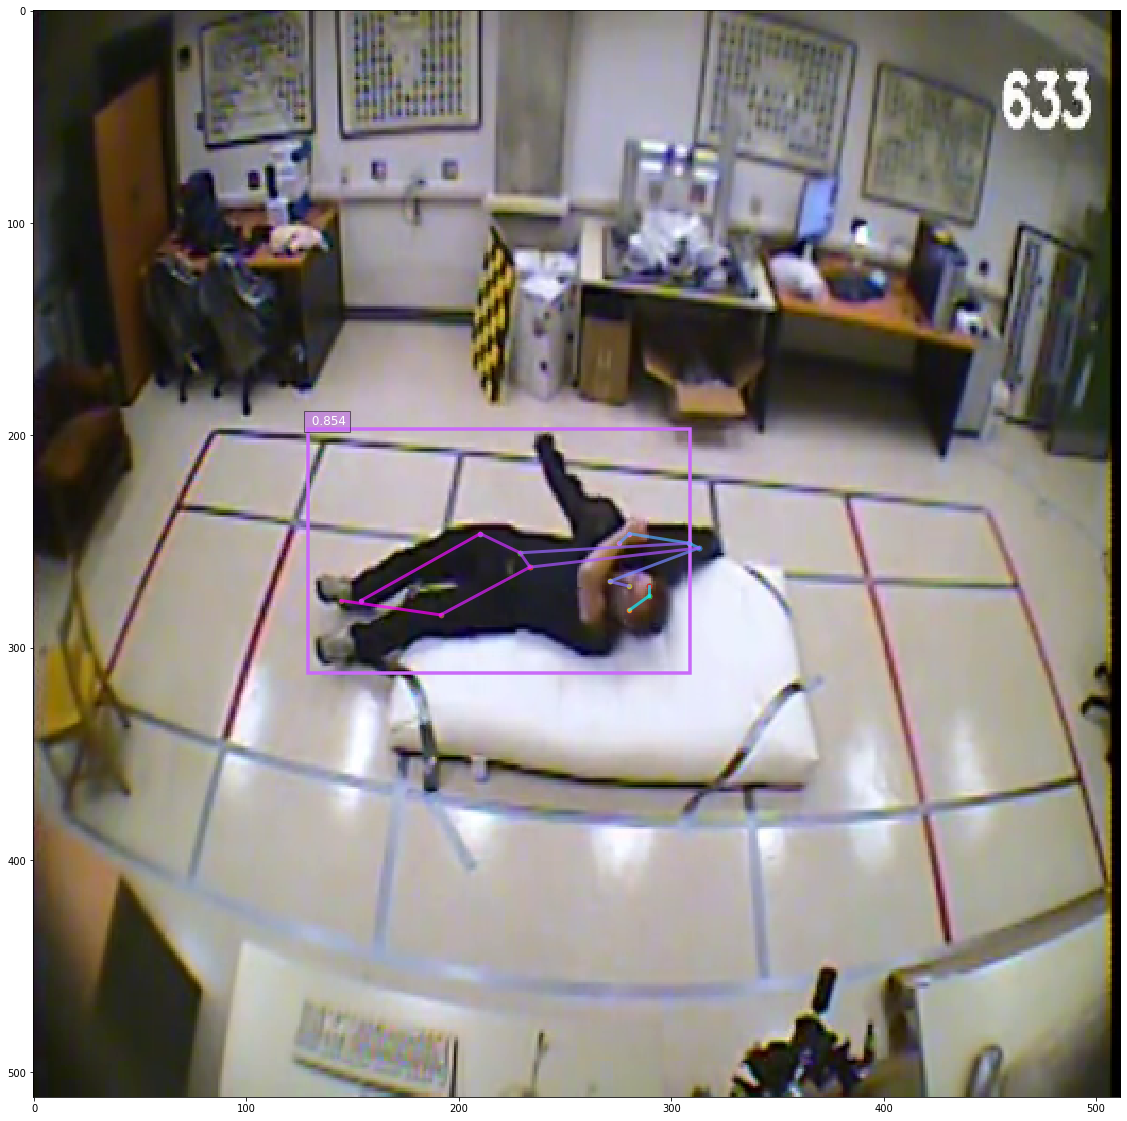

In [15]:
from nb_utils import get_frames, get_video_stats, get_predictions, to_mx, to_np


frame_num = 290
print("Frame number : ", frame_num)
get_predictions(
    sample_frames[frame_num],
    detector_model,
    pose_model,
    img_size,
    person_id=0,
    visualize=True,
)


frame_num = 400
print("Frame number : ", frame_num)
get_predictions(
    sample_frames[frame_num],
    detector_model,
    pose_model,
    img_size,
    person_id=0,
    visualize=True,
)


frame_num = 633
print("Frame number : ", frame_num)
get_predictions(
    sample_frames[frame_num],
    detector_model,
    pose_model,
    img_size,
    person_id=0,
    visualize=True,
)

Ankle shoulder distance reduces from 154 pixels to 26 pixels as the person falls.

Let's define variables to track ankle to shoulder distance.

* `xpart_tracker` - is a dictionary that tracks the x coordinates of keypoints of shoulders, ankles in numpy array
* `ypart_tracker` - is a dictionary that tracks the y coordinates of keypoints of shoulders, ankles in numpy array
* ankle to shoulder distance will be measured by `ypart_tracker['shdr']-ypart_tracker['anks']`.

The fall detection assessment is carried out in function `fall_detection`. <br>
**Fall** is declared when ankle to shoulder distance `anks-shdr` distance along y-axis reduces below `anks-shdr-thresh`

#### Step 4: Combine all rules

The below example code does inference only on the mid 100 frames and flags a fall.

In [16]:
def fall_detection(ypart_tracker, anks_shdr_thresh, dist_hist=50, dist_count=5):
    """
    :param ypart_tracker: y points tracker
    :param anks_shdr_thresh: threshold for distance
    :param dist_hist: number of points in history to consider
    :param dist_count: threshold for number of occurrences of low anks-shdr distance
    :return: Fall result
    """
    dist_cndt = np.sum(ypart_tracker["anks-shdr"][-dist_hist:] <= anks_shdr_thresh)

    if dist_cndt > dist_count:
        return True
    else:
        return False

In [17]:
# !mkdir logs # folder to save fall-frame
import os

try:
    os.mkdir('logs/')

except Exception as e:
    print('{}'.format(e))

[Errno 17] File exists: 'logs/'


In [18]:
# Initialize variables for inference and tracking

xpart_tracker, ypart_tracker = reset_tracker()  # Keypoint tracking list
(
    frame_num,
    frame_prev,
    frame_curr,
    zero_dets,
) = reset_counts()  # Frame numbers tracking

# preprocessing
img_size = (512, 512)

# Person detection variables
conf_thresh = 0.1
person_id = 0
box_size_thresh = (75, 75)

# Fall variables
anks_shdr_thresh = 50  # Threshold for ankle shoulder distance
dist_hist = 50  # Number of frames in the past to evaluate distance
dist_count = 5  # Number of frames where ankle shoulder distance goes below dist_hist

# Tracking variables
fall_idx = -1  # Last fall frame number
min_non_dets = 20  # count of minimum number of non-detection frames
fall_interval = 1000  # number of frames to consider next fall

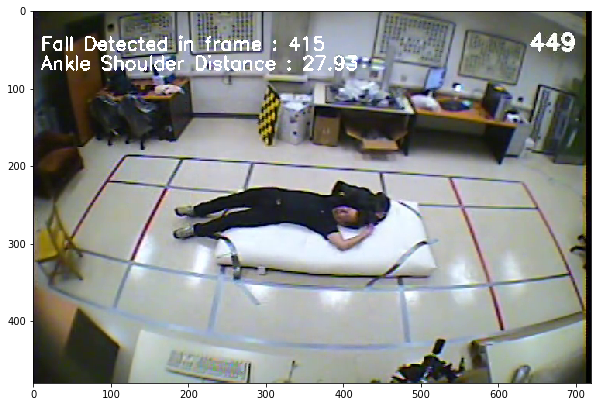

In [19]:
# Loading the video using opencv
cap = cv2.VideoCapture(video_path)

i = 0

# Looping through the video
while (cap.isOpened()) and i < video_stats["total_frames"]:

    (fetch, frame) = cap.read()
    # Convert to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    i += 1

    if i < 350 or i > 450:
        continue

    x, orig_img = preprocess(frame, img_size)
    x, orig_img = mx.nd.array(x), mx.nd.array(orig_img)

    # Detect person
    box_ids, scores, bboxes = detector_model(x)
    x_min, y_min, x_max, y_max = (
        bboxes[0][0][0],
        bboxes[0][0][1],
        bboxes[0][0][2],
        bboxes[0][0][3],
    )
    w, h = (x_max - x_min).asscalar(), (y_max - y_min).asscalar()

    # Check for minimum person detection confidence and bbox dimension of person
    if (
        (scores[:, 0:1, :][0][0].asscalar() > conf_thresh)
        and w > box_size_thresh[0]
        and h > box_size_thresh[1]
    ):

        orig_img, box_ids, scores, bboxes = (
            to_np(orig_img),
            to_np(box_ids),
            to_np(scores),
            to_np(bboxes),
        )

        # get pose keypoints
        try:
            # Crop the bbox area from detector output from original image, transform it for pose model
            pose_input, upscale_bbox = detector_to_simple_pose(
                orig_img,
                box_ids[:, 0:1, :],
                scores[:, 0:1, :],
                bboxes[:, 0:1, :],
                thr=conf_thresh,
                person_id=person_id,
            )

            pose_input, upscale_bbox = to_mx(pose_input), to_mx(upscale_bbox)
            # process pose model output to get key point coordinates
            predicted_heatmap = pose_model(pose_input)
            predicted_heatmap, upscale_bbox = to_np(predicted_heatmap), to_np(
                upscale_bbox
            )
            pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

            # Append current prediction to previous
            xpart_tracker = update_x(pred_coords[0][:, 0], xpart_tracker)
            ypart_tracker = update_y(pred_coords[0][:, 1], ypart_tracker)

            result = fall_detection(
                ypart_tracker, anks_shdr_thresh, dist_hist, dist_count
            )

            if result:
                # Flag next fall after fall_interval frames
                if fall_idx == -1 or (i - fall_idx) >= (fall_interval):
                    time_stamp = time.strftime(
                        "%Y-%m-%d %H:%M:%S", time.gmtime(time.time())
                    )
                    print(f"Fall Detected at {time_stamp} {i}, saving image to logs.")
                    fall_idx = i

        except Exception as e:
            print("Exception: {}".format(e))
            break

    else:
        # Reset tracker if no person is detected for more than `min_non_dets` continuous frames
        if zero_dets > min_non_dets:
            xpart_tracker, ypart_tracker = reset_tracker()
            frame_num, frame_prev, frame_curr, zero_dets = reset_counts()
            continue
        # Track consecutive non detections
        frame_prev, frame_curr = frame_curr, frame_num
        if frame_curr - frame_prev == 1:
            zero_dets += 1
        else:
            zero_dets = 0

    frame_num += 1
    dist = round((ypart_tracker["anks"][-1] - ypart_tracker["shdr"][-1]), 2)
    cv2.putText(
        frame,
        "Fall Detected in frame : {}".format(max(-1, fall_idx-1)),
        (10, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (255, 255, 255),
        2,
    )
    cv2.putText(
        frame,
        "Ankle Shoulder Distance : {}".format(dist),
        (10, 75),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (255, 255, 255),
        2,
    )
    
    # Save the fall image
    if fall_idx == i: plt.imsave("logs/fall.jpg", frame)
        
    # Output the frame
    plt.figure(figsize=(10, 10))
    plt.imshow(frame)
    plt.show()

    # Clear output
    clear_output(wait=True)

    # observe the keypress by the user
    keypress = cv2.waitKey(1) & 0xFF

    # if the user pressed "q", then stop looping
    if keypress == ord("q"):
        breakq

# free up memory
cap.release()
cv2.destroyAllWindows()

## Structuring the Lambda Function

The above 4 steps showed how to process inference from pose estimation model to frame rules for fall detection. <br>
In order to deploy "Fall Detection application", the code above has to be converted into a structured lambda function.<br> The generic template is given below.

In [27]:
# Lambda skeleton
class FallDetection(object):
    def interface(self):
        # defines the parameters that interface with other services from Panorama
        return

    def init(self, parameters, inputs, outputs):
        # defines the attributes such as arrays and model objects that will be used in the application
        return

    def entry(self, inputs, outputs):
        # defines the application logic responsible for predicting using the inputs and handles what to do
        # with the outputs
        return

The code below closely follows the lambda function script in Lambda/FallDetection.py

#### Imports

In [28]:
import os
import sys
path = os.path.abspath(os.path.join(os.path.dirname("panorama_sdk"), '../..'))
sys.path.insert(1, path + '/panorama_sdk')


from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

import utils as lambda_utils


from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

#### Loading models in Python Panoramasdk

In [29]:
import panoramasdk

pose_model = panoramasdk.model()
pose_model.open('simple_pose_resnet50_v1d', 1)


detector_model = panoramasdk.model()
detector_model.open('ssd_512_resnet50_v1_voc', 1)



# Create input and output arrays.
class_info = detector_model.get_output(0)
prob_info = detector_model.get_output(1)
rect_info = detector_model.get_output(2)

class_array = np.empty(class_info.get_dims(), dtype=class_info.get_type())
prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())
rect_array = np.empty(rect_info.get_dims(), dtype=rect_info.get_type())


heatmap_info = pose_model.get_output(0)
heatmaps_array = np.empty(heatmap_info.get_dims(), dtype=heatmap_info.get_type())


#### Preprocessing

In [30]:
def preprocess(img, size):

    resized = cv2.resize(img, (size, size))
    mean = [0.485, 0.456, 0.406]  # RGB
    std = [0.229, 0.224, 0.225]  # RGB

    img = resized.astype(np.float32) / 255.  # converting array of ints to floats
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)
    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c
    x1 = np.asarray(x1)

    return x1

#### Load Image

In [31]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/pose/soccer.png?raw=true',
                          path='soccer.png')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

Shape of pre-processed image: (1, 3, 512, 605)


#### get person detection and pose detection in Panoramasdk

In [32]:
# Pre Process Frame
x1 = preprocess(img, 512)

# Do inference on the new frame.
detector_model.batch(0, x1)
detector_model.flush()

# Get the results.
resultBatchSet = detector_model.get_result()

class_batch = resultBatchSet.get(0)
prob_batch = resultBatchSet.get(1)
rect_batch = resultBatchSet.get(2)

class_batch.get(0, class_array)
prob_batch.get(1, prob_array)
rect_batch.get(2, rect_array)

class_data = class_array[0]
prob_data = prob_array[0]
rect_data = rect_array[0]



pose_input, upscale_bbox = lambda_utils.detector_to_simple_pose(img,  class_array, prob_array, rect_array, person_index = 14.0)

# Do inference on the new frame.
pose_model.batch(0, pose_input)
pose_model.flush()




PresultBatchSet = pose_model.get_result()
heatmaps_batch = PresultBatchSet.get(0)
heatmaps_batch.get(0, heatmaps_array)
predicted_heatmap = heatmaps_array
pose_model.release_result(PresultBatchSet)



# # process pose model output to get key point coordinates
pred_coords, confidence = lambda_utils.heatmap_to_coord(predicted_heatmap, upscale_bbox)
pred_coords = np.round(pred_coords, 3)

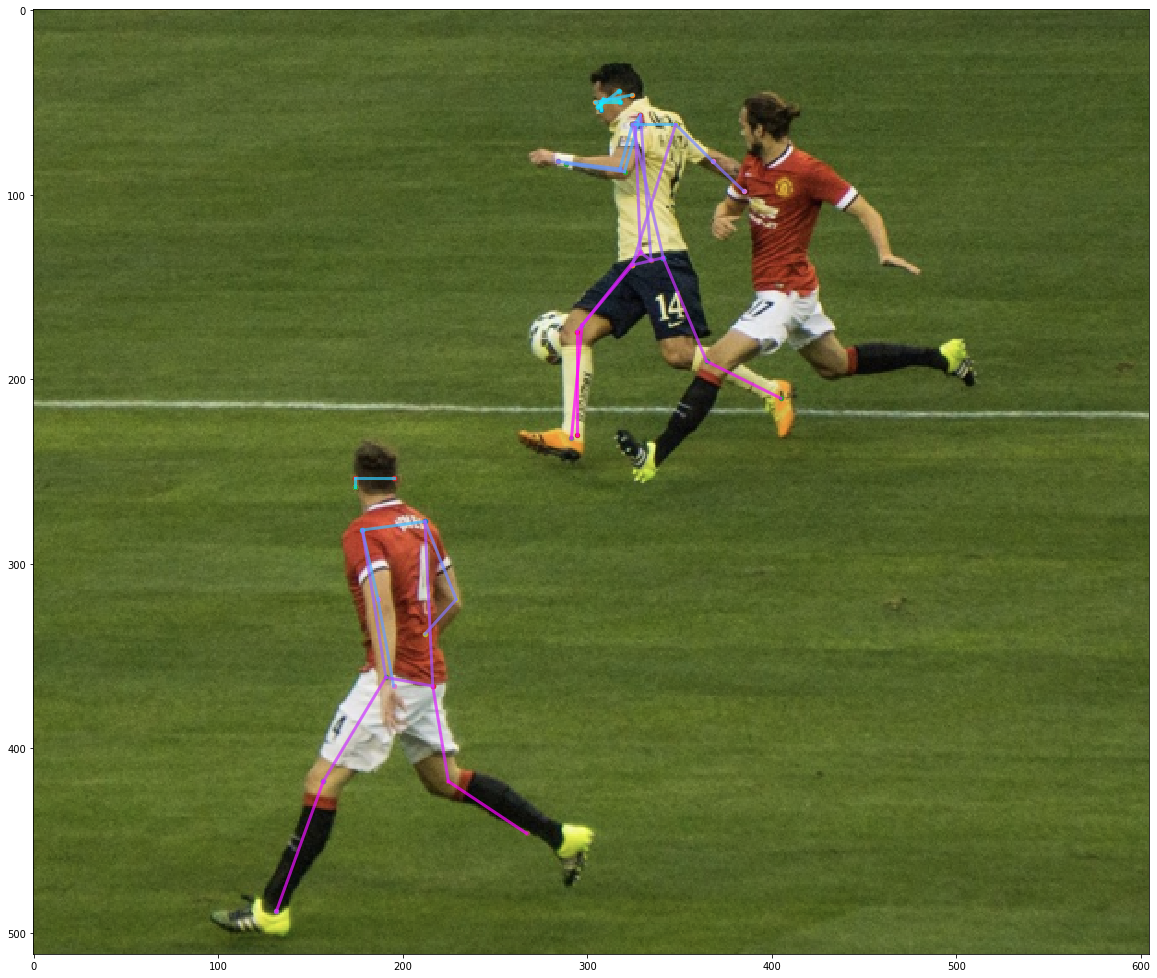

In [33]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_array, rect_array, prob_array,
                              box_thresh=0.5, keypoint_thresh=0.2)
plt.show()

#### Stucturing the Lambda for the Fall Detection Usecase

In [25]:
import boto3
import json
import time
import matplotlib.pyplot as plt

# gluoncv dependencies for model, visualization
import mxnet as mx
from mxnet import nd
from gluoncv.model_zoo import get_model
from gluoncv import data, utils

# lambda helper script
from notebook_utils import (
    reset_counts,
    reset_tracker,
    update_x,
    preprocess,
    update_y,
    fall_detection,
    detector_to_simple_pose,
    heatmap_to_coord,
)

# notebook specific helper script
from nb_utils import get_video_stats, get_frames, to_np, to_mx
from IPython.display import clear_output, Markdown, display


%matplotlib inline

In [26]:
video_path = "sample_video.mp4"
video_stats = get_video_stats(video_path, verbose=False)

model_params = {
    "detector_name": "ssd_512_resnet50_v1_coco",
    "pose_name": "simple_pose_resnet50_v1d",
    "pretrained": True,
    "person_id": 0,
    "conf_thresh": 0.1,
}

input_params = {
    "video_name": video_path,
    "img_size": (512, 512),
}

fall_constraints = {
    "box_size_thresh": (75, 75),
    "min_non_dets": 20,
    "dist_hist": 50,
    "dist_count": 5,
    "anks_shdr_thresh": 50,
    "fall_interval": 1000,
    "verbose": False,
}


class FallDetection:
    def __init__(self):

        try:
            self.fall_constraints = fall_constraints
            self.input_params = input_params
            self.model_params = model_params

            self.detector_model, self.pose_model = self._init_model(**model_params)
            self.conf_thresh = model_params["conf_thresh"]
            self.person_id = model_params["person_id"]

            self.video_name = input_params["video_name"]
            self.img_size = input_params["img_size"]

            self.min_non_dets = fall_constraints["min_non_dets"]
            self.box_size_thresh = fall_constraints["box_size_thresh"]
            self.anks_shdr_thresh = fall_constraints["anks_shdr_thresh"]
            self.dist_hist = fall_constraints["dist_hist"]
            self.dist_count = fall_constraints["dist_count"]
            self.fall_interval = fall_constraints["fall_interval"]

            self.verbose = fall_constraints["verbose"]

        except Exception as e:
            print("Exception: {}".format(e))

    def _init_model(self, **model_params):

        detector_model = get_model(
            model_params["detector_name"], pretrained=model_params["pretrained"]
        )
        pose_model = get_model(
            model_params["pose_name"], pretrained=model_params["pretrained"]
        )
        detector_model.reset_class(["person"], reuse_weights=["person"])

        return detector_model, pose_model

    def entry(self):

        xpart_tracker, ypart_tracker = reset_tracker()  # Keypoint tracking list
        (
            frame_num,
            frame_prev,
            frame_curr,
            zero_dets,
        ) = reset_counts()  # Frame numbers tracking
        fall_idx = -1

        # Loading the video using opencv
        cap = cv2.VideoCapture(self.video_name)
        i = 0

        # Looping through the video
        while (cap.isOpened()) and i < video_stats["total_frames"]:

            (fetch, frame) = cap.read()
            # Convert to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            i += 1

            if i < 350 or i > 450:
                continue

            x, orig_img = preprocess(frame, self.img_size)
            x, orig_img = mx.nd.array(x), mx.nd.array(orig_img)

            # Detect person
            box_ids, scores, bboxes = self.detector_model(x)
            x_min, y_min, x_max, y_max = (
                bboxes[0][0][0],
                bboxes[0][0][1],
                bboxes[0][0][2],
                bboxes[0][0][3],
            )
            w, h = (x_max - x_min).asscalar(), (y_max - y_min).asscalar()

            # Check for minimum person detection confidence and bbox dimension of person
            if (
                (scores[:, 0:1, :][0][0].asscalar() > self.conf_thresh)
                and w > self.box_size_thresh[0]
                and h > self.box_size_thresh[1]
            ):

                orig_img, box_ids, scores, bboxes = (
                    to_np(orig_img),
                    to_np(box_ids),
                    to_np(scores),
                    to_np(bboxes),
                )

                # get pose keypoints
                try:
                    # Crop the bbox area from detector output from original image, transform it for pose model
                    pose_input, upscale_bbox = detector_to_simple_pose(
                        orig_img,
                        box_ids[:, 0:1, :],
                        scores[:, 0:1, :],
                        bboxes[:, 0:1, :],
                        thr=self.conf_thresh,
                        person_id=self.person_id,
                    )

                    pose_input, upscale_bbox = to_mx(pose_input), to_mx(upscale_bbox)

                    predicted_heatmap = self.pose_model(pose_input)
                    predicted_heatmap, upscale_bbox = to_np(predicted_heatmap), to_np(
                        upscale_bbox
                    )
                    # process pose model output to get key point coordinates
                    pred_coords, confidence = heatmap_to_coord(
                        predicted_heatmap, upscale_bbox
                    )

                    # Append current prediction to previous
                    xpart_tracker = update_x(pred_coords[0][:, 0], xpart_tracker)
                    ypart_tracker = update_y(pred_coords[0][:, 1], ypart_tracker)

                    result = fall_detection(
                        ypart_tracker,
                        self.anks_shdr_thresh,
                        self.dist_hist,
                        self.dist_count,
                    )

                    if result:
                        # Flag next fall after fall_interval frames
                        if fall_idx == -1 or (i - fall_idx) >= (self.fall_interval):
                            time_stamp = time.strftime(
                                "%Y-%m-%d %H:%M:%S", time.gmtime(time.time())
                            )
                            print(
                                f"Fall Detected at {time_stamp} {i}, saving image to logs."
                            )
                            fall_idx = i

                except Exception as e:
                    print("Exception: {}".format(e))
                    continue

            else:
                # Reset tracker if no person is detected for more than `min_non_dets` continuous frames
                if zero_dets > self.min_non_dets:
                    xpart_tracker, ypart_tracker = reset_tracker()
                    frame_num, frame_prev, frame_curr, zero_dets = reset_counts()
                    continue
                # Track consecutive non detections
                frame_prev, frame_curr = frame_curr, frame_num
                if frame_curr - frame_prev == 1:
                    zero_dets += 1
                else:
                    zero_dets = 0

            frame_num += 1

            dist = round((ypart_tracker["anks"][-1] - ypart_tracker["shdr"][-1]), 2)
            cv2.putText(
                frame,
                "Fall Detected in frame : {}".format(max(-1, fall_idx-1)),
                (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (255, 255, 255),
                2,
            )
            cv2.putText(
                frame,
                "Ankle Shoulder Distance : {}".format(dist),
                (10, 75),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (255, 255, 255),
                2,
            )
            # Save the fall image
            if fall_idx == i: plt.imsave("logs/fall.jpg", frame)
            
            # Output the frame
            plt.figure(figsize=(10, 10))
            plt.imshow(frame)
            plt.show()

            # Clear output
            clear_output(wait=True)

            # observe the keypress by the user
            keypress = cv2.waitKey(1) & 0xFF

            # if the user pressed "q", then stop looping
            if keypress == ord("q"):
                break

        # free up memory
        cap.release()
        cv2.destroyAllWindows()


def main():
    FallDetection().entry()

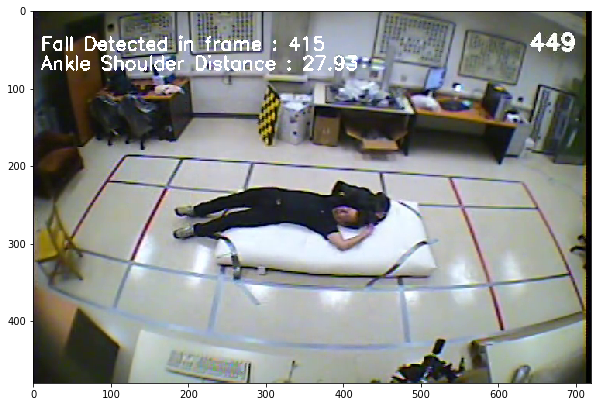

In [27]:
main()

## 4. Publish to AWS Lambda

* A lambda is already provided and ready for use in the Lambda folder (zip file)
* Use this code snippet to upload and publish it to Lambda Service

#### AWS CLI credentials

This Python snippet uses boto3 to create an IAM role named LambdaBasicExecution with basic 
lambda execution permissions.

#### 2.2 Create Role

In [28]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}

iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="FallDetectionExecutionRole",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

{'Role': {'Path': '/',
  'RoleName': 'FallDetectionExecutionRole',
  'RoleId': 'AROAZAPJMVFPGYARWHMTJ',
  'Arn': 'arn:aws:iam::619501627742:role/FallDetectionExecutionRole',
  'CreateDate': datetime.datetime(2020, 11, 6, 21, 39, 9, tzinfo=tzlocal()),
  'AssumeRolePolicyDocument': {'Version': '2012-10-17',
   'Statement': [{'Effect': 'Allow',
     'Principal': {'Service': 'lambda.amazonaws.com'},
     'Action': ['sts:AssumeRole']},
    {'Effect': 'Allow',
     'Principal': {'Service': 'events.amazonaws.com'},
     'Action': ['sts:AssumeRole']}]}},
 'ResponseMetadata': {'RequestId': '67d863b7-de26-4320-bb90-bc15f56673cc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '67d863b7-de26-4320-bb90-bc15f56673cc',
   'content-type': 'text/xml',
   'content-length': '983',
   'date': 'Fri, 06 Nov 2020 21:39:09 GMT'},
  'RetryAttempts': 0}}

#### 2.3 Create Lambda

In [34]:
!zip -o ../Lambda/fall-detection.zip ../Lambda/fall_detector.py ../Lambda/utils.py

  adding: ../Lambda/fall_detector.py (deflated 75%)
  adding: ../Lambda/utils.py (deflated 70%)


In [31]:
import boto3

lambda_client = boto3.client("lambda")

with open("../Lambda/fall-detection.zip", "rb") as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName="FallDetectionExecutionRole")
response_create_function = lambda_client.create_function(
    FunctionName="FallDetectionLambda",
    Runtime="python3.7",
    Role=role["Role"]["Arn"],
    Handler="fall_detector.main()",
    Code=dict(ZipFile=zipped_code),
    Timeout=120,  # Maximum allowable timeout
    MemorySize=2048,
)


# Publish Lambda
response = lambda_client.publish_version(FunctionName="FallDetectionLambdaDemo")

**What is an ARN?** : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function created above, and return an ARN with a version. 

This version arn can be used to go directly to the Panorama console and deploy this application.

In [32]:
response = lambda_client.publish_version(FunctionName="FallDetectionLambda")

Printing the details of the lambda function that was just published

In [33]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
    
function_arn = response["FunctionArn"]
function_arn_version = list(response["FunctionArn"].split(":"))[-1]
lambda_url = (
    "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/"
    + response["FunctionName"]
    + "/versions/"
    + response["Version"]
    + "?tab=configuration"
)

printmd("**Function Arn** : **{}**".format(function_arn), color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version), color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url), color="black")

<span style='color:black'>**Function Arn** : **arn:aws:lambda:us-east-1:619501627742:function:FallDetectionLambda:1**</span>

<span style='color:black'>**Function Arn Version** : **1**</span>

<span style='color:black'>**Lambda Console Link** : **https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/FallDetectionLambda/versions/1?tab=configuration**</span>

## 5. Upload Models

In [34]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = '../../Models/' + model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, model)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return

#### Pose Model

In [35]:
send_model_to_s3(model = 'simple_pose_resnet50_v1d.tar.gz')

<span style='color:black'>**S3 Path** : **s3://aws-panorama-models-bucket/../Models/simple_pose_resnet50_v1d.tar.gz**</span>

#### Object Detection Model

In [36]:
send_model_to_s3(model = 'ssd_512_resnet50_v1_voc.tar.gz')

<span style='color:black'>**S3 Path** : **s3://aws-panorama-models-bucket/../Models/ssd_512_resnet50_v1_voc.tar.gz**</span>

## 6. Deploy the Application

The Lambda is now created and published. You are now ready to deploy your model and the published lambda function, to the Panorama device

The instructions to deploy are linked below

[Creating Application Instructions Here](https://docs.aws.amazon.com/panorama/)

## 7. Extending the notebook

- The choice of keypoints is subjective. 
- One can choose those body-parts that appear consistenly over video (for high confidence, less noisy prediction)  and measure distance accordingly.
- Choose the fall detection thresholds based on the dataset and camera angle orientation.


